# [HYPOTHESIS] Pending transfers that have intermediate errors are technical failures

### Context

We believe that there are specific intermediate/sender error codes that result in failed GP2GP transfers, and therefore should be interpreted as failed. We will know this to be true when we can see in the data that some intermediate/sender errors result in failures.

This notebook is to:
- identify if there are any error codes (sender, or intermediate) that we never recover from 
- for each error code, breakdown the transfers by the resulting outcome 
- present the probability of success per error code and rank in order of most likely to succeed

This analysis is for a 6 month time frame - From September 2020 to February 2021 (using transfers dataset).

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
transfer_file_location = "s3://<bucket-name>/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet",
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

In [3]:
def group_by_errors(error_field, df):
    transfers_with_errors = df.groupby([error_field, 'status']).count()[['conversation_id']].unstack().fillna(0)
    transfers_with_errors.columns = transfers_with_errors.columns.get_level_values(1)
    transfers_with_errors["total_count"] = transfers_with_errors[["PENDING_WITH_ERROR","FAILED","INTEGRATED"]].sum(axis=1)
    transfers_with_errors= transfers_with_errors.astype(int)
    return transfers_with_errors.sort_values(by=['INTEGRATED','PENDING_WITH_ERROR'], ascending=[False,False])

In [4]:
def generate_percentages(df):
    transfers_with_percentage = df.iloc[:, 0:3].apply(lambda x: x / df.iloc[:, 3] * 100)
    transfers_with_percentage = transfers_with_percentage.sort_values(by=['INTEGRATED', 'PENDING_WITH_ERROR'], ascending=[False,False])
    transfers_with_percentage = transfers_with_percentage.add_suffix(' (%)')
    return transfers_with_percentage.round(2)

## Transfers with sender errors

In [5]:
transfers_with_sender_errors = group_by_errors('sender_error_code', transfers)
transfers_with_sender_errors

status,PENDING_WITH_ERROR,INTEGRATED,FAILED,total_count
sender_error_code,,,,
20.0,2840,1111,1035,4986
19.0,311,76,44,431
14.0,10168,3,0,10171
23.0,418,3,2,423
30.0,7381,0,0,7381
10.0,3515,0,0,3515
6.0,897,0,0,897
7.0,723,0,0,723
24.0,134,0,1,135


In [6]:
transfers_with_sender_errors_percentage = generate_percentages(transfers_with_sender_errors)
transfers_with_sender_errors_percentage

status,PENDING_WITH_ERROR (%),INTEGRATED (%),FAILED (%)
sender_error_code,,,
20.0,56.96,22.28,20.76
19.0,72.16,17.63,10.21
23.0,98.82,0.71,0.47
14.0,99.97,0.03,0.00
30.0,100.00,0.00,0.00
10.0,100.00,0.00,0.00
6.0,100.00,0.00,0.00
7.0,100.00,0.00,0.00
99.0,100.00,0.00,0.00


## Conclusion

The table above shows that it is possible to recover from the following errors recorded by the sender and that transfers with these errors may be eventually integrated:
- error code **20** (22.28% integrated) - *Spine system  responded with an error*
- error code **19** (17.63% integrated) - *Sender check indicates that Requester is not the patient’s current healthcare provider*
- error code **23** (0.71% integrated) - *Message not sent because sending practice is not Large Message compliant*
- error code **14** (0.03% integrated) - *Message not sent because requestingpractice is not Large Message compliant*

## Transfers with intermediate errors

In [7]:
has_intermediate_errors = transfers["intermediate_error_codes"].apply(len) > 0
transfers_with_intermediate_errors_exploded = transfers[has_intermediate_errors].explode("intermediate_error_codes")
transfers_with_unique_intermediate_errors = transfers_with_intermediate_errors_exploded.drop_duplicates(subset=["conversation_id", "intermediate_error_codes"])

transfers_with_intermediate_errors = group_by_errors("intermediate_error_codes", transfers_with_unique_intermediate_errors)
transfers_with_intermediate_errors

status,FAILED,INTEGRATED,PENDING_WITH_ERROR,total_count
intermediate_error_codes,,,,
29,1207,397,42,1646
12,50,52,8,110
30,4,10,4,18
25,2,2,1,5
31,17,2,0,19
11,19,1,5,25
15,5,0,79,84
99,6,0,9,15
20,0,0,1,1


### Caveat

For transfers with multiple different error codes, each error code will be counted as a new transfer.

In [8]:
transfers_with_intermediate_errors_percentage = generate_percentages(transfers_with_intermediate_errors)
transfers_with_intermediate_errors_percentage

status,FAILED (%),INTEGRATED (%),PENDING_WITH_ERROR (%)
intermediate_error_codes,,,
30,22.22,55.56,22.22
12,45.45,47.27,7.27
25,40.00,40.00,20.00
29,73.33,24.12,2.55
31,89.47,10.53,0.00
11,76.00,4.00,20.00
20,0.00,0.00,100.00
26,0.00,0.00,100.00
15,5.95,0.00,94.05


## Conclusion

The table above shows that it is possible to recover from the following intermediate errors and that transfers with these errors may be eventually integrated:
- error code **30** (55.56% integrated) - *Large Message general failure*
- error code **12** (47.27% integrated) - *Duplicate EHR Extract received*
- error code **25** (40% integrated) - *Large messages rejected due to timeout duration reached of overall transfer*
- error code **29** (24.12% integrated) - *Large Message Re-assembly failure*
- error code **31** (10.53% integrated) - *The overall EHR Extract has been rejected because one or more attachments via Large Messageswere not received*
- error code **11** (4% integrated) - *Failed to successfully integrate EHR Extract*

## Merging sender and intermediate errors

In [44]:
transfers_with_sender_and_intermediate_errors = pd.concat([transfers_with_sender_errors, transfers_with_intermediate_errors])
transfers_with_sender_and_intermediate_errors = transfers_with_sender_and_intermediate_errors.groupby(transfers_with_sender_and_intermediate_errors.index).sum()
transfers_with_sender_and_intermediate_errors = transfers_with_sender_and_intermediate_errors.sort_values(by=['INTEGRATED', 'total_count'], ascending=[False,False])
transfers_with_sender_and_intermediate_errors

,PENDING_WITH_ERROR,INTEGRATED,FAILED,total_count
20.0,2841,1111,1035,4987
29.0,42,397,1207,1646
19.0,311,76,44,431
12.0,8,52,50,110
30.0,7385,10,4,7399
14.0,10168,3,0,10171
23.0,418,3,2,423
31.0,0,2,17,19
25.0,1,2,2,5
11.0,5,1,19,25


In [11]:
transfers_with_sender_and_intermediate_errors_percentage = generate_percentages(transfers_with_sender_and_intermediate_errors)
transfers_with_sender_and_intermediate_errors_percentage

,PENDING_WITH_ERROR (%),INTEGRATED (%),FAILED (%)
12.0,7.27,47.27,45.45
25.0,20.00,40.00,40.00
29.0,2.55,24.12,73.33
20.0,56.97,22.28,20.75
19.0,72.16,17.63,10.21
31.0,0.00,10.53,89.47
11.0,20.00,4.00,76.00
23.0,98.82,0.71,0.47
30.0,99.81,0.14,0.05
14.0,99.97,0.03,0.00


In [45]:
transfers_with_sender_and_intermediate_errors_total = transfers_with_sender_and_intermediate_errors.merge(transfers_with_sender_and_intermediate_errors_percentage, left_index=True, right_index=True, how="outer")
transfers_with_sender_and_intermediate_errors_total = transfers_with_sender_and_intermediate_errors_total#.loc[:,['PENDING_WITH_ERROR (%)', 'FAILED (%)', 'INTEGRATED (%)', 'total_count']] 
transfers_with_sender_and_intermediate_errors_total = transfers_with_sender_and_intermediate_errors_total.sort_values(by=["INTEGRATED (%)", "total_count"], ascending=[False,False])
transfers_with_sender_and_intermediate_errors_total

,PENDING_WITH_ERROR,INTEGRATED,FAILED,total_count,PENDING_WITH_ERROR (%),INTEGRATED (%),FAILED (%)
12.0,8,52,50,110,7.27,47.27,45.45
25.0,1,2,2,5,20.00,40.00,40.00
29.0,42,397,1207,1646,2.55,24.12,73.33
20.0,2841,1111,1035,4987,56.97,22.28,20.75
19.0,311,76,44,431,72.16,17.63,10.21
31.0,0,2,17,19,0.00,10.53,89.47
11.0,5,1,19,25,20.00,4.00,76.00
23.0,418,3,2,423,98.82,0.71,0.47
30.0,7385,10,4,7399,99.81,0.14,0.05
14.0,10168,3,0,10171,99.97,0.03,0.00


## Conclusion


In [58]:
integration_failure_groups=transfers_with_sender_and_intermediate_errors_total[['INTEGRATED (%)','INTEGRATED','total_count']].sort_values(by=['INTEGRATED','total_count'],ascending=[False,False])
integration_failure_groups.loc[[20,29,19,12],'Conclusion']='Non-fatal error: Some chance of Integration'
integration_failure_groups.loc[[30,14,23],'Conclusion']='Seems fatal: Tiny chance of Integration'
integration_failure_groups.loc[[31,25,11],'Conclusion']='Seems Non-fatal: Not enough data'
integration_failure_groups.loc[[10,6,7,24,99,15],'Conclusion']='Likely Fatal Error: Common errors with no integrations'
integration_failure_groups.loc[[28,17,21,26,205],'Conclusion']='Possibly Fatal Error: Not enough data'
integration_failure_groups=integration_failure_groups.reset_index().rename({'index':'Error Code'},axis=1).set_index(['Conclusion','Error Code'])
integration_failure_groups

INTEGRATED (%)  \
Conclusion                                         Error Code                   
Non-fatal error: Some chance of Integration        20.0                 22.28   
                                                   29.0                 24.12   
                                                   19.0                 17.63   
                                                   12.0                 47.27   
Seems fatal: Tiny chance of Integration            30.0                  0.14   
                                                   14.0                  0.03   
                                                   23.0                  0.71   
Seems Non-fatal: Not enough data                   31.0                 10.53   
                                                   25.0                 40.00   
                                                   11.0                  4.00   
Likely Fatal Error: Common errors with no integ... 10.0                  0.00   
                                                   6.0                   0.00   
                                                   7.0                   0.00   
                                                   24.0                  0.00   
                                                   99.0                  0.00   
                                                   15.0                  0.00   
Possibly Fatal Error: Not enough data              28.0                  0.00   
                                                   17.0                  0.00   
                                                   21.0                  0.00   
                                                   26.0                  0.00   
                                                   205.0                 0.00   

                                                               INTEGRATED  \
Conclusion                                         Error Code               
Non-fatal error: Some chance of Integration        20.0              1111   
                                                   29.0               397   
                                                   19.0                76   
                                                   12.0                52   
Seems fatal: Tiny chance of Integration            30.0                10   
                                                   14.0                 3   
                                                   23.0                 3   
Seems Non-fatal: Not enough data                   31.0                 2   
                                                   25.0                 2   
                                                   11.0                 1   
Likely Fatal Error: Common errors with no integ... 10.0                 0   
                                                   6.0                  0   
                                                   7.0                  0   
                                                   24.0                 0   
                                                   99.0                 0   
                                                   15.0                 0   
Possibly Fatal Error: Not enough data              28.0                 0   
                                                   17.0                 0   
                                                   21.0                 0   
                                                   26.0                 0   
                                                   205.0                0   

                                                               total_count  
Conclusion                                         Error Code               
Non-fatal error: Some chance of Integration        20.0               4987  
                                                   29.0               1646  
                                                   19.0                431  
                                          


The table above shows that it is possible to recover from the following errors and that transfers with these errors may be eventually integrated:
- error code **12** (47.27% integrated) - *Duplicate EHR Extract received*
- error code **25** (40% integrated) - *Large messages rejected due to timeout duration reached of overall transfer*
- error code **29** (24.12% integrated) - *Large Message Re-assembly failure*
- error code **20** (22.28% integrated) - *Spine system  responded with an error*
- error code **19** (17.63% integrated) - *Sender check indicates that Requester is not the patient’s current healthcare provider*
- error code **31** (10.53% integrated) - *The overall EHR Extract has been rejected because one or more attachments via Large Messageswere not received*
- error code **11** (4% integrated) - *Failed to successfully integrate EHR Extract*
- error code **23** (0.71% integrated) - *Message not sent because sending practice is not Large Message compliant*
- error code **30** (0.14% integrated) - *Large Message general failure*
- error code **14** (0.03% integrated) - *Message not sent because requesting practice is not Large Message compliant*

None of the above errors overlapped between sender and intermediate errors, except error code 20 which was sometimes integrated when it was reported as a sender error (1111/4986), and was not integrated when it was reported as an intermediate error (0/1).

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


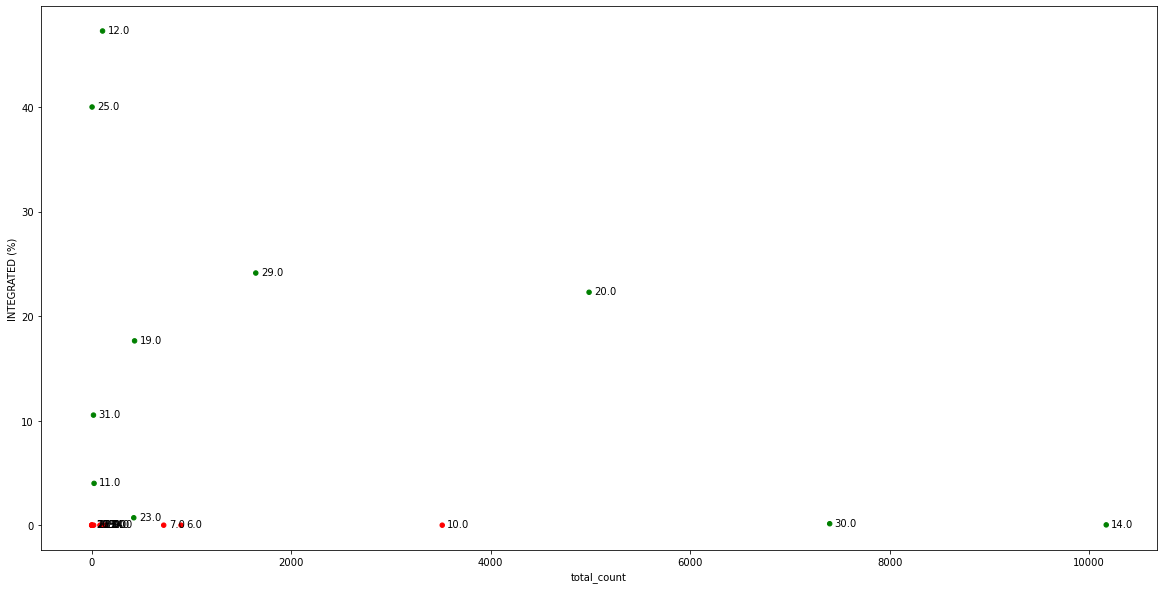

In [43]:
PlotData=transfers_with_sender_and_intermediate_errors_total[['total_count','INTEGRATED (%)']]
PlotData['colour']='green'
PlotData.loc[PlotData['INTEGRATED (%)']==0,'colour']='red'
PlotData.plot.scatter(x='total_count',y='INTEGRATED (%)',c='colour',figsize=(20,10))
LabellingData=PlotData.reset_index()[['total_count','INTEGRATED (%)','index']]
LabellingData['total_count']=LabellingData['total_count']+50
LabellingData['INTEGRATED (%)']=LabellingData['INTEGRATED (%)']-0.2
LabellingData.apply(lambda row: plt.gca().text(*row),axis=1);
